# XGBoost models informed by feature selection analysis (using 1 k-fold)
## SHAP interactions between YEAR and STROKE TEAM

### Plain English summary

To look at the interaction of feature Year with Stroke team (as year is only selected in the feature list if stroke team an option too).

SHAP interactions can not be calculated for multiclass classification. Instead train binary models, converting the target feature (disability_discharge) into a binary feature by predicting one class vs the rest. Have seven models (predict mRS0 vs mRS1-6, predict mRS1 vs rest, predict mRS2 vs rest, predict mRS3 vs rest, predict mRS4 vs rest, predict mRS5 vs rest, predict mRS6 vs mRS0-5)  

Use just first kfold as seen performance of model is consistent across the 5 data divisions.

This model includes 8 features "prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known", "year"]\
First k-fold\

### Model and data
XGBoost\
8 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known", "year"]\
First k-fold\

### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb




## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

import seaborn as sns

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import importlib
import copy
# Import local package
#from utils import waterfall
## Force package to be reloaded
#importlib.reload(waterfall);

# Need for cm subplots?
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from matplotlib.colors import LogNorm
#from matplotlib.ticker import MultipleLocator

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

Use just the first k-fold split

In [3]:
k = 0
target_feature = 'discharge_disability'
n_binary_models = 6

Select the features for the model

In [4]:
x_selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                       "age", "any_afib_diagnosis", 
                       "onset_to_thrombolysis_time", "precise_onset_time", 
                       "year"]
n_features = len(x_selected_features)

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    output_save_path: str = './output/'
    model_save_path: str = './saved_models/'
    data_read_path: str = '../data/kfold_5fold/'
    model_text: str = (f'xgb_{n_features}_features_1kfold'
                       f'_binary')
    notebook: str = '090'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the first kfold split

In [10]:
train_data = pd.read_csv(paths.data_read_path + '03_train_{0}.csv'.format(k))
test_data = pd.read_csv(paths.data_read_path + '03_test_{0}.csv'.format(k))

In [ ]:
def convert_feature_to_binary(df, target_feature, binary_threshold):
    df[f'binary_{binary_threshold}'] = 0
    df[f'binary_{binary_threshold}'] = (df[target_feature] <= binary_threshold) * 1
    df.drop([target_feature],axis=1,inplace=True)
    return(df)

In [ ]:
def setup_binary_feature(binary_threshold, x_selected_features):
    dict = {}
    dict["binary_target_feature"] = f'binary_{binary_threshold}'
    dict["selected_features"] = x_selected_features.append(dict["binary_target_feature"])
    return(dict)

Prepare the datasets for this binary threshold level

In [ ]:
def prepare_datasets(train_data, target_feature, binary_threshold, selected_features):
    train_data = convert_feature_to_binary(train_data, target_feature, binary_threshold)
    train_data = train_data[selected_features]

    test_data = convert_feature_to_binary(test_data, target_feature, binary_threshold)
    test_data = test_data[selected_features]
    return(train_data, test_data)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [ ]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Create function to return X and y data for train and test sets

In [ ]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Define function to fit XGBoost model

In [ ]:
def fit_xgb_model(filename):

    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        print("Run notebook 080 which trains the model")
    return(model)

Define function to calculate preditions from model

In [ ]:
def model_predictions(model, X_test, y_test):
    # Get target categories from model
#    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)

    # Get and store predicted class
    y_pred = model.predict(X_test)

    return(y_probs, y_pred)

In [ ]:
def fit_shap_explainer(filename, model, X_train):

    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            explainer = pickle.load(filehandler)

    else:

       # Set up explainer using the model and feature values from training set
       explainer = shap.TreeExplainer(model, X_train)

        # Save explainer using pickle
       with open(filename, 'wb') as filehandler:
           pickle.dump(explainer, filehandler)
        
    return(explainer)

Function to calculate SHAP values

In [ ]:
def calculate_shap_values_extended(filename, explainer, X_test):
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)

        # Save shap values extendedr using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
        return(shap_values_extended)

### Calculate SHAP interaction values
A SHAP interaction value is returned for each pair of features (including with itself, which is known as the main effect), for each instance. The SHAP value for a feature is the sum of it's pair-wise feature interactions.

We will use the TreeExplainer (from the shap library: https://shap.readthedocs.io/en/latest/index.html) to calculate the SHAP interaction values.

'Raw' SHAP interaction values from XGBoost model are log odds ratios.

Either load from pickle (if file exists), or calculate.

In [ ]:
def calculate_shap_interactions(filename, explainer, X_test):
# Load SHAP interation values, or calculate from explainer

    file_exists = exists(filename)

    if file_exists:
        # Load SHAP interaction
        with open(filename, 'rb') as filehandler:
            shap_interactions = pickle.load(filehandler)
    else:

        # Calculate SHAP interaction values
        shap_interactions = explainer.shap_interaction_values(X_test)
        
        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_interactions, filehandler)
    
    return(shap_interactions)

Code to setup data per binary threshold, fit model and analyse performance

In [ ]:
y_test_binary = []
y_pred_binary = []

# Include the new binary feature we calculate (replaces the multiclass feature)
for binary_threshold in range(n_binary_models):
    print(f"Model using binary threshold {binary_threshold}")
    dict_binary = setup_binary_feature(binary_threshold, x_selected_features)
#    binary_target_feature = f'binary_{binary_threshold}'
#    selected_features = x_selected_features.append(binary_target_feature)
    (train_data, test_data) = prepare_datasets(train_data, target_feature, binary_threshold, x_selected_features)
    #Keep copy of original test data, with 'Stroke team' not one-hot encoded
    test_data_orig = test_data.copy(deep=True)
    train_data_orig = train_data.copy(deep=True)

    feature = "stroke_team"
    prefix = "team_"
    if feature in list(train_data):
        train_data = convert_feature_to_one_hot(train_data, feature, prefix)
        test_data = convert_feature_to_one_hot(test_data, feature, prefix)

    feature_names_ohe = list(train_data)
    feature_names_ohe.remove(dict_binary["binary_target_feature"])
    n_features = len(feature_names_ohe)


    # Get k fold split (this notebook is only using kfold split 0)
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data,
                                                      test_data,
                                                      dict_binary["binary_target_feature"])
    y_test_binary.append(y_test)

    # Model filename
    filename = os.path.join(paths.model_save_path, (paths.notebook + paths.model_text + binary_threshold + '.p'))
    
    ## Fit XGBoost model
    model = fit_xgb_model(filename)

    # SHAP explainer filename
    filename = os.path.join(paths.output_save_path, (paths.notebook + paths.model_text + binary_threshold + '_shap_explainer.p'))

    ## Load SHAP values
    shap_explainer = fit_shap_explainer(filename, model, X_train)

    # SHAP values filename
    filename = os.path.join(paths.output_save_path, (paths.notebook + paths.model_text + binary_threshold + '_shap_values_extended.p'))

    ## Load SHAP values
    shap_values_extended = calculate_shap_values_extended(filename, model, X_test)
    shap_values = shap_values_extended.values
    
    # SHAP interactions filename
    filename = os.path.join(paths.output_save_path, (paths.notebook + paths.model_text + binary_threshold + '_shap_interactions.p'))

    ## Calculate SHAP interaction values
    shap_interactions = calculate_shap_interactions(filename, shap_explainer, X_test)

    (y_probs, y_pred) = model_predictions(model, X_test, y_test)
    
    # Get ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
    roc_auc = auc(fpr, tpr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)

    print (f'Accuracy: {accuracy:0.3f} ')
    print (f'ROCAUC: {roc_auc:0.3f}')
    print()

SHAP interaction values have a matrix of values (per pair of features) per instance.
In this case, each of the 88792 instances has a 139x139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [49]:
shap_interactions[0,:,:].std()

0.008544068

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [50]:
shap_interactions[0]

array([[ 7.74189830e-01, -6.30364120e-02, -4.02250839e-03, ...,
         3.95002317e-05,  1.00635155e-03, -7.20539188e-04],
       [-6.30364269e-02, -6.36874557e-01,  2.92934794e-02, ...,
        -1.21891161e-03, -9.59323734e-05,  1.77050440e-03],
       [-4.02251072e-03,  2.92934831e-02, -1.00472175e-01, ...,
         3.61144412e-05,  2.59662174e-05, -1.01356115e-03],
       ...,
       [ 3.95002280e-05, -1.21891161e-03,  3.61144412e-05, ...,
         3.83879454e-03,  0.00000000e+00,  0.00000000e+00],
       [ 1.00635155e-03, -9.59324243e-05,  2.59662138e-05, ...,
         0.00000000e+00,  2.01413943e-03,  0.00000000e+00],
       [-7.20539130e-04,  1.77050417e-03, -1.01356162e-03, ...,
         0.00000000e+00,  0.00000000e+00, -1.11661814e-02]], dtype=float32)

Get the interaction between hosptial and year


Get the index for the year (already got the index for the individual hosptials in earlier section)

In [51]:
# Store the column index for the year feature
year_index = X_test.columns.get_loc("year")

Function to add columns to a dataframe

### Format the SHAP interaction data

Features are in the same order in shap_interaction as they are in the original dataset. Use this fact to extract the SHAP interaction between year and each one-hot encoded hospital features.

Create a dataframe containing the SHAP values: an instance per row, and an interaction with each one-hot encoded hospital feature per column.

In [52]:
df_hosp_year_shap_interactions = create_df_one_hot_encoded_hosp_features(
                    shap_values_wo_background, hospital_columns_index, 
                    hospital_names)
df_hosp_year_shap_interactions = add_columns_to_df(
                        df_hosp_year_shap_interactions, 
                        test_data_orig["stroke_team"].values)

In [53]:
hosp_year_shap_interactions = []

# Use index list to access the hosptial shap values (as array) in the loop below
for i in range(shap_interactions.shape[0]):
    # Get the year interaction with each hospital
    hosp_year_shap_interactions.append(shap_interactions[i][year_index][hospital_columns_index])

# Put in dataframe with hospital as column title
df_hosp_year_shap_interactions = pd.DataFrame(hosp_year_shap_interactions, 
                                         columns = hospital_names)

df_hosp_year_shap_interactions = add_columns_to_df(df_hosp_year_shap_interactions, test_data_orig["stroke_team"].values)

df_hosp_year_shap_interactions.head()

,Addenbrooke's Hospital,Basildon University Hospital,Blackpool Victoria Hospital,Bradford and Airedale SU,Bronglais Hospital,Broomfield Hospital,Calderdale Royal Hospital,Charing Cross Hospital HASU,Chesterfield Royal,Colchester General Hospital,...,Worcestershire Royal Hospital,Worthing Hospital,Wycombe General Hospital,Yeovil District Hospital,York Hospital,Ysbyty Gwynedd,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.001008,-0.000977,0.001753,-0.000636,-0.035335,-0.000445,-0.001862,0.002964,-0.000716,0.000109,...,-0.006031,0.0,-0.000834,-0.000128,0.001057,0.003567,Bronglais Hospital,-0.057379,-0.035335,-0.022044
1,0.001055,-0.000977,0.002670,-0.000435,0.000286,-0.000103,-0.001885,0.002387,-0.000114,0.000255,...,-0.003939,0.0,-0.000253,-0.000313,0.000888,0.006614,William Harvey Hospital,0.534889,0.537602,-0.002712
2,0.001054,-0.000797,0.002441,-0.000665,0.000286,0.000074,-0.001906,0.002322,-0.000114,0.000255,...,-0.005305,0.0,-0.000635,-0.000313,0.000791,0.006632,Prince Charles Hospital,-0.055366,-0.034511,-0.020854
3,0.000460,-0.000123,0.002022,-0.000405,0.000080,-0.000103,-0.002024,0.002321,-0.000048,0.000255,...,-0.005773,0.0,-0.000835,-0.000313,0.000773,0.006911,Cumberland Infirmary,-0.576564,-0.551671,-0.024892
4,0.001054,-0.000977,0.002135,-0.000636,0.000286,-0.000103,-0.001862,0.002320,-0.000050,0.000255,...,-0.004468,0.0,-0.000834,-0.000313,0.000773,0.006516,University Hospitals of North Tees and Hartlepool,-0.010030,0.005641,-0.015671


### Format the SHAP interaction data

Features are in the same order in shap_interaction as they are in the original dataset. Use this fact to extract the SHAP main effect values for the one-hot encoded hospital features.

Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

In [54]:
hosp_shap_main_effects = []

# Use index list to access the hosptial shap values (as array) in the loop below
for i in range(shap_interactions.shape[0]):
    # Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interactions[i])
    hosp_shap_main_effects.append(main_effects[hospital_columns_index])
    
# Put in dataframe with hospital as column title
df_hosp_shap_main_effects = pd.DataFrame(hosp_shap_main_effects, 
                                         columns = hospital_names)

In [55]:
df_hosp_shap_main_effects = add_columns_to_df(df_hosp_shap_main_effects, 
                                              test_data_orig["stroke_team"].values)

In [56]:
df_hosp_shap_main_effects.head()

,Addenbrooke's Hospital,Basildon University Hospital,Blackpool Victoria Hospital,Bradford and Airedale SU,Bronglais Hospital,Broomfield Hospital,Calderdale Royal Hospital,Charing Cross Hospital HASU,Chesterfield Royal,Colchester General Hospital,...,Worcestershire Royal Hospital,Worthing Hospital,Wycombe General Hospital,Yeovil District Hospital,York Hospital,Ysbyty Gwynedd,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.001087,-0.002335,-0.008930,-0.003608,-0.185649,-0.003575,0.006789,0.001749,0.000883,0.004399,...,0.004701,-0.002705,0.000347,0.003839,0.002014,-0.011166,Bronglais Hospital,-0.226306,-0.185649,-0.040658
1,0.001017,-0.002335,-0.010982,-0.003707,0.000299,-0.003795,0.006812,0.002121,0.000464,0.003863,...,0.001875,-0.002705,-0.000039,0.003740,0.002255,-0.013925,William Harvey Hospital,0.289339,0.336427,-0.047088
2,0.000972,-0.002596,-0.010640,-0.003552,0.000299,-0.003560,0.006777,0.002164,0.000438,0.003863,...,0.004147,-0.002705,0.000208,0.003716,0.002374,-0.013163,Prince Charles Hospital,-0.289728,-0.250854,-0.038874
3,0.001420,-0.002827,-0.010212,-0.003729,0.000392,-0.003794,0.006999,0.002190,0.000141,0.003863,...,0.004435,-0.002627,0.000349,0.003717,0.002184,-0.013188,Cumberland Infirmary,-0.487286,-0.449143,-0.038143
4,0.001097,-0.002243,-0.010838,-0.003581,0.000260,-0.003794,0.006864,0.002188,0.000167,0.003863,...,0.002764,-0.002705,0.000347,0.003716,0.002295,-0.012217,University Hospitals of North Tees and Hartlepool,0.564770,0.600826,-0.036056


### Create boxplot (range of SHAP values and SHAP main effect across 132 hospitals)
Analyse the range of SHAP values and SHAP main effect values for the one-hot encoded hospital features. Show as two populations: the attended hospital, the sum of the hospitals not attended

To create a grouped boxplot, used code from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots

To define HEX colour codes use http://colorbrewer2.org/

In [57]:
def set_box_color(bp, color):
    """
    bp [boxplot object]
    color [Hex Color Codes]
    """
    
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['means'], color=color)

    return()

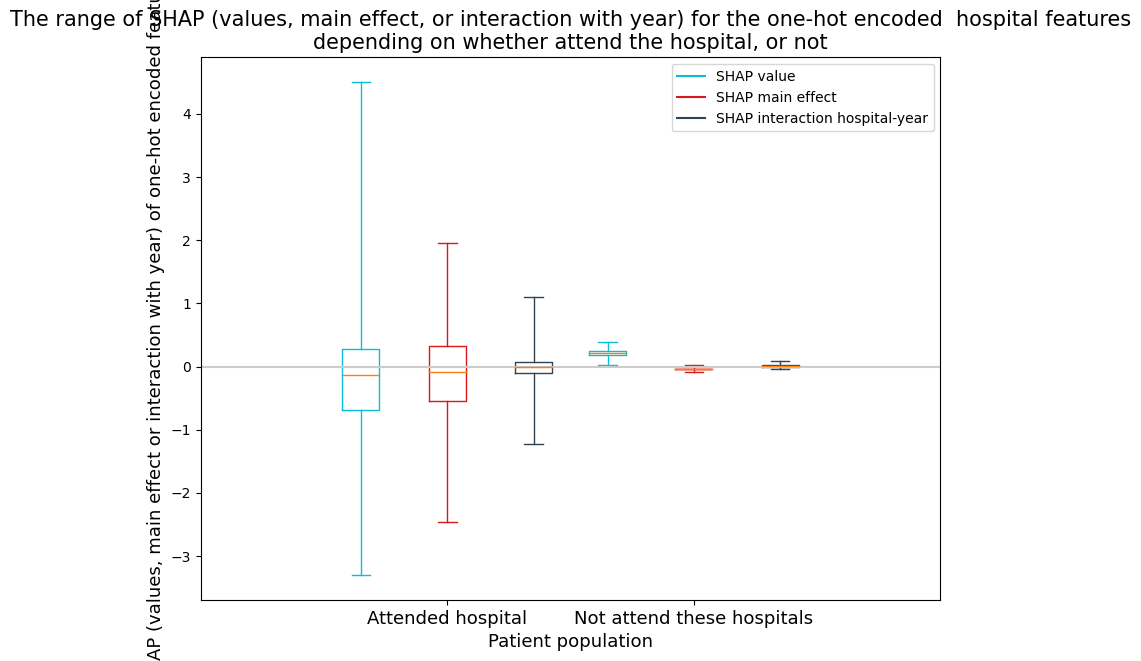

In [58]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ticks = ["Attended hospital", "Not attend these hospitals"]

# SHAP value for plot
# A list of two lists, the values in each list create a box on the plot
plot_data_sv = [df_hosp_shap_values["attended_stroke_team"], 
                df_hosp_shap_values["not_attended_stroke_teams"]]
bp_sv = plt.boxplot(plot_data_sv, 
                  positions=np.array(range(len(plot_data_sv)))*2.0-0.7, 
                  sym='', whis=99999, widths=0.3)
set_box_color(bp_sv, '#0bbed8')

# SHAP main effect for plot
# A list of two lists, the values in each list create a box on the plot
plot_data_me = [df_hosp_shap_main_effects["attended_stroke_team"], 
                df_hosp_shap_main_effects["not_attended_stroke_teams"]]
bp_me = plt.boxplot(plot_data_me, 
                  positions=np.array(range(len(plot_data_me)))*2.0, 
                  sym='', whis=99999, widths=0.3)
set_box_color(bp_me, '#D7191C')

# SHAP interaction with year for plot
# A list of two lists, the values in each list create a box on the plot
plot_data_yhi = [df_hosp_year_shap_interactions["attended_stroke_team"], 
                df_hosp_year_shap_interactions["not_attended_stroke_teams"]]
bp_yhi = plt.boxplot(plot_data_yhi, 
                  positions=np.array(range(len(plot_data_yhi)))*2.0+0.7, 
                  sym='', whis=99999, widths=0.3)
set_box_color(bp_yhi, '#314451')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#0bbed8', label='SHAP value')
plt.plot([], c='#D7191C', label='SHAP main effect')
plt.plot([], c='#314451', label='SHAP interaction hospital-year')
plt.legend()

# X axis
plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=13)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()

# Add line at Shap = 0
ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 

title = ("The range of SHAP (values, main effect, or interaction with year) for the one-hot encoded "
         " hospital features\ndepending on whether attend the hospital, or not")
plt.title(title, size=15)
plt.ylabel('SHAP (values, main effect or interaction with year) of one-hot encoded feature', size=13)
plt.xlabel('Patient population', size=13)

plt.savefig(f'./{paths.output_save_path}/{paths.notebook}_{paths.model_text}'
            f'_hosp_shap_value_main_effect_interaction_attend_vs_notattend_boxplot.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

# Interaction between ST and Year

Repeat above Boxplot but with individual hospital, and include the SHAP interaction between Year and StrokeTeamas a third box per hospital.

Create boxplot (range of SHAP values and SHAP main effect within each 132 hospitals)
Create a boxplot to show the range of SHAP values and SHAP main effect values for each individual one-hot encoded hospital feature.

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP main effect, and mean SHAP values for each hosptial (for those instances that attended the hospital)

In [59]:
def shap_descriptive_stats(hospital_names, df_hosp_shap, prefix_text):
    """
    For a set of columns (those contained in "hospital_names"), take only the
    values which represented a hospital attended (using a mask from column 
    "stroke team". Return the descripive values of the IQR for the attended 
    hospital values (in a dataframe with hospital as row and each IQR as a 
    column.
    
    hospital_names [list]: The list of unique hospital names
    df_hosp_shap [DataFrame]: Contains a value per hospital (column) per 
                              patient (row)
    prefix_text [string]: Define what values are in the dataframe
    return [DataFrame]: A hospital per row and each IQR as a column
    """
    
    # Create list of values (one per hospital) for those instances that attend 
    #   the hospital. Store the IQR for all the patients that attend the
    #   hospital
    attend_stroketeam_min = []
    attend_stroketeam_q1 = []
    attend_stroketeam_mean = []
    attend_stroketeam_q3 = []
    attend_stroketeam_max = []
    
    for h in hospital_names:
        mask = df_hosp_shap['Stroke team'] == h
        data_stroke_team = df_hosp_shap[h][mask]
        q1, q3 = np.percentile(data_stroke_team, [25,75])
        attend_stroketeam_min.append(data_stroke_team.min())
        attend_stroketeam_q1.append(q1)
        attend_stroketeam_mean.append(data_stroke_team.mean())
        attend_stroketeam_q3.append(q3)
        attend_stroketeam_max.append(data_stroke_team.max())

    # Create dataframe with six columns (hospital and descriptive stats)
    df = pd.DataFrame(hospital_names, columns=[f"hospital_{prefix_text}"])
    df[f"shap_min_{prefix_text}"] = attend_stroketeam_min
    df[f"shap_q1_{prefix_text}"] = attend_stroketeam_q1
    df[f"shap_mean_{prefix_text}"] = attend_stroketeam_mean
    df[f"shap_q3_{prefix_text}"] = attend_stroketeam_q3
    df[f"shap_max_{prefix_text}"] = attend_stroketeam_max
    
    return(df)

Calculate the descriptive stats (IQR values) for the range of SHAP values (and main effect) for the attended hospital.

In [60]:
df_me = shap_descriptive_stats(hospital_names, df_hosp_shap_main_effects, "me")
df_sv = shap_descriptive_stats(hospital_names, df_hosp_shap_values, "sv")
df_ysi = shap_descriptive_stats(hospital_names, df_hosp_year_shap_interactions, "ysi")

Join the dataframes together (SHAP valeus and SHAP main effect) in one dataframe

In [61]:
df_hosp_shap_descriptive_stats = df_me.join([df_sv,df_ysi])
df_hosp_shap_descriptive_stats.drop(columns=["hospital_sv","hospital_ysi"], inplace=True)
df_hosp_shap_descriptive_stats.rename(columns={"hospital_me": "hospital"}, 
                                      inplace=True)

Sort in descending SHAP main effect value order

In [62]:
df_hosp_shap_descriptive_stats.sort_values("shap_mean_me", 
                                           ascending=False, inplace=True)                
df_hosp_shap_descriptive_stats.head(5)

,hospital,shap_min_me,shap_q1_me,shap_mean_me,shap_q3_me,shap_max_me,shap_min_sv,shap_q1_sv,shap_mean_sv,shap_q3_sv,shap_max_sv,shap_min_ysi,shap_q1_ysi,shap_mean_ysi,shap_q3_ysi,shap_max_ysi
77,Royal Stoke University Hospital,1.192149,1.549622,1.613296,1.673926,1.950535,0.679851,1.417298,1.861690,2.200447,3.097587,-0.442094,-0.140910,-0.003177,0.091673,0.344429
2,Blackpool Victoria Hospital,1.194900,1.381616,1.444965,1.502614,1.697654,0.410517,0.788106,1.272812,1.672460,2.405804,-0.492495,-0.239586,-0.000799,0.220020,0.563460
117,Ysbyty Gwynedd,1.017514,1.205196,1.258535,1.310818,1.527410,0.468878,0.890759,1.277820,1.611941,2.131830,-0.694727,-0.083378,0.018628,0.232970,0.332571
49,North Devon District Hospital,0.777502,1.153765,1.208879,1.278368,1.551503,0.579945,1.098285,1.636048,1.987557,4.502473,-0.549492,-0.343823,-0.027438,0.249508,1.098558
74,Royal Liverpool University Hospital,0.718352,1.053717,1.103528,1.176272,1.375996,0.211972,0.972081,1.294874,1.520468,2.521660,-0.552844,-0.115226,-0.018686,0.103331,0.485597


Want to add admission figures to xlabel in boxplot. Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [63]:
data_train_test = test_data_orig.append(train_data_orig)
data_train_test["thrombolysis"] = (data_train_test["onset_to_thrombolysis_time"] > -100) * 1
#X_combined_stroketeam = (
#        test_data_orig["stroke_team"].append(train_data_orig["stroke_team"]))

# Get list of unique stroke team names
unique_stroketeams_list = list(set(data_train_test["stroke_team"]))#X_combined_stroketeam))

# Calculate admissions to each team
admissions = [((data_train_test["stroke_team"]) == s).sum() for s in unique_stroketeams_list]

# Create dataframe with stroke team and admissions
df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["Stroke team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("Stroke team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = data_train_test.groupby(by=["stroke_team"]).mean()["thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)
df_stroketeam_ivt_adms.columns = ["Admissions","Thrombolysis"]
df_stroketeam_ivt_adms

,Admissions,Thrombolysis
Stroke team,,
University Hospitals Dorset Stroke Service,358,0.189944
Warwick Hospital,358,0.058659
Bronglais Hospital,363,0.325069
Weston General Hospital,461,0.173536
West Wales General,465,0.283871
...,...,...
Stepping Hill Hospital,2774,0.175919
University College Hospital HASU,2902,0.152653
Queen Alexandra Hospital Portsmouth,3041,0.255508


Create data for boxplot

In [64]:
# Go through order of hospital in Dataframe (ordered on mean SHAP main effect)
hospital_order = df_hosp_shap_descriptive_stats["hospital"]
    
# Initiate lists 
# 1) SHAP main effect (one per hospital) for instances that attend stroke team
# 2) SHAP value (one per hospital) for instances that attend stroke team
# 2) SHAP interaction with year (one per hospital) for instances that attend stroke team
me_attend_stroketeam_groups_ordered = []
sv_attend_stroketeam_groups_ordered = []    
ysi_attend_stroketeam_groups_ordered = []    

# Initiate lists 
# 1) SHAP main effect (one per hospital) for instances that don't attend stroke 
#    team
# 2) SHAP value (one per hospital) for instances that don't attend stroke team
# 3) SHAP interaction with year (one per hospital) for instances that don't attend stroke team
me_not_attend_stroketeam_groups_ordered = []
sv_not_attend_stroketeam_groups_ordered = []
ysi_not_attend_stroketeam_groups_ordered = []

# Initiate list for xlabels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_main_effects['Stroke team'] == h
    me_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    sv_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    ysi_attend_stroketeam_groups_ordered.append(df_hosp_year_shap_interactions[h][mask])
    
    # Not attend
    mask = df_hosp_shap_main_effects['Stroke team'] != h
    me_not_attend_stroketeam_groups_ordered.append(
                                            df_hosp_shap_main_effects[h][mask])
    sv_not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    ysi_not_attend_stroketeam_groups_ordered.append(df_hosp_year_shap_interactions[h][mask])
    
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['Thrombolysis'].loc[h] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                  f"{ivt_rate}%)")

Resource for using overall y min and max of both datasets on the 4 plots so have the same range https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists.

Shows the range of contributions to the prediction from this hospital when patients attend this hosptial


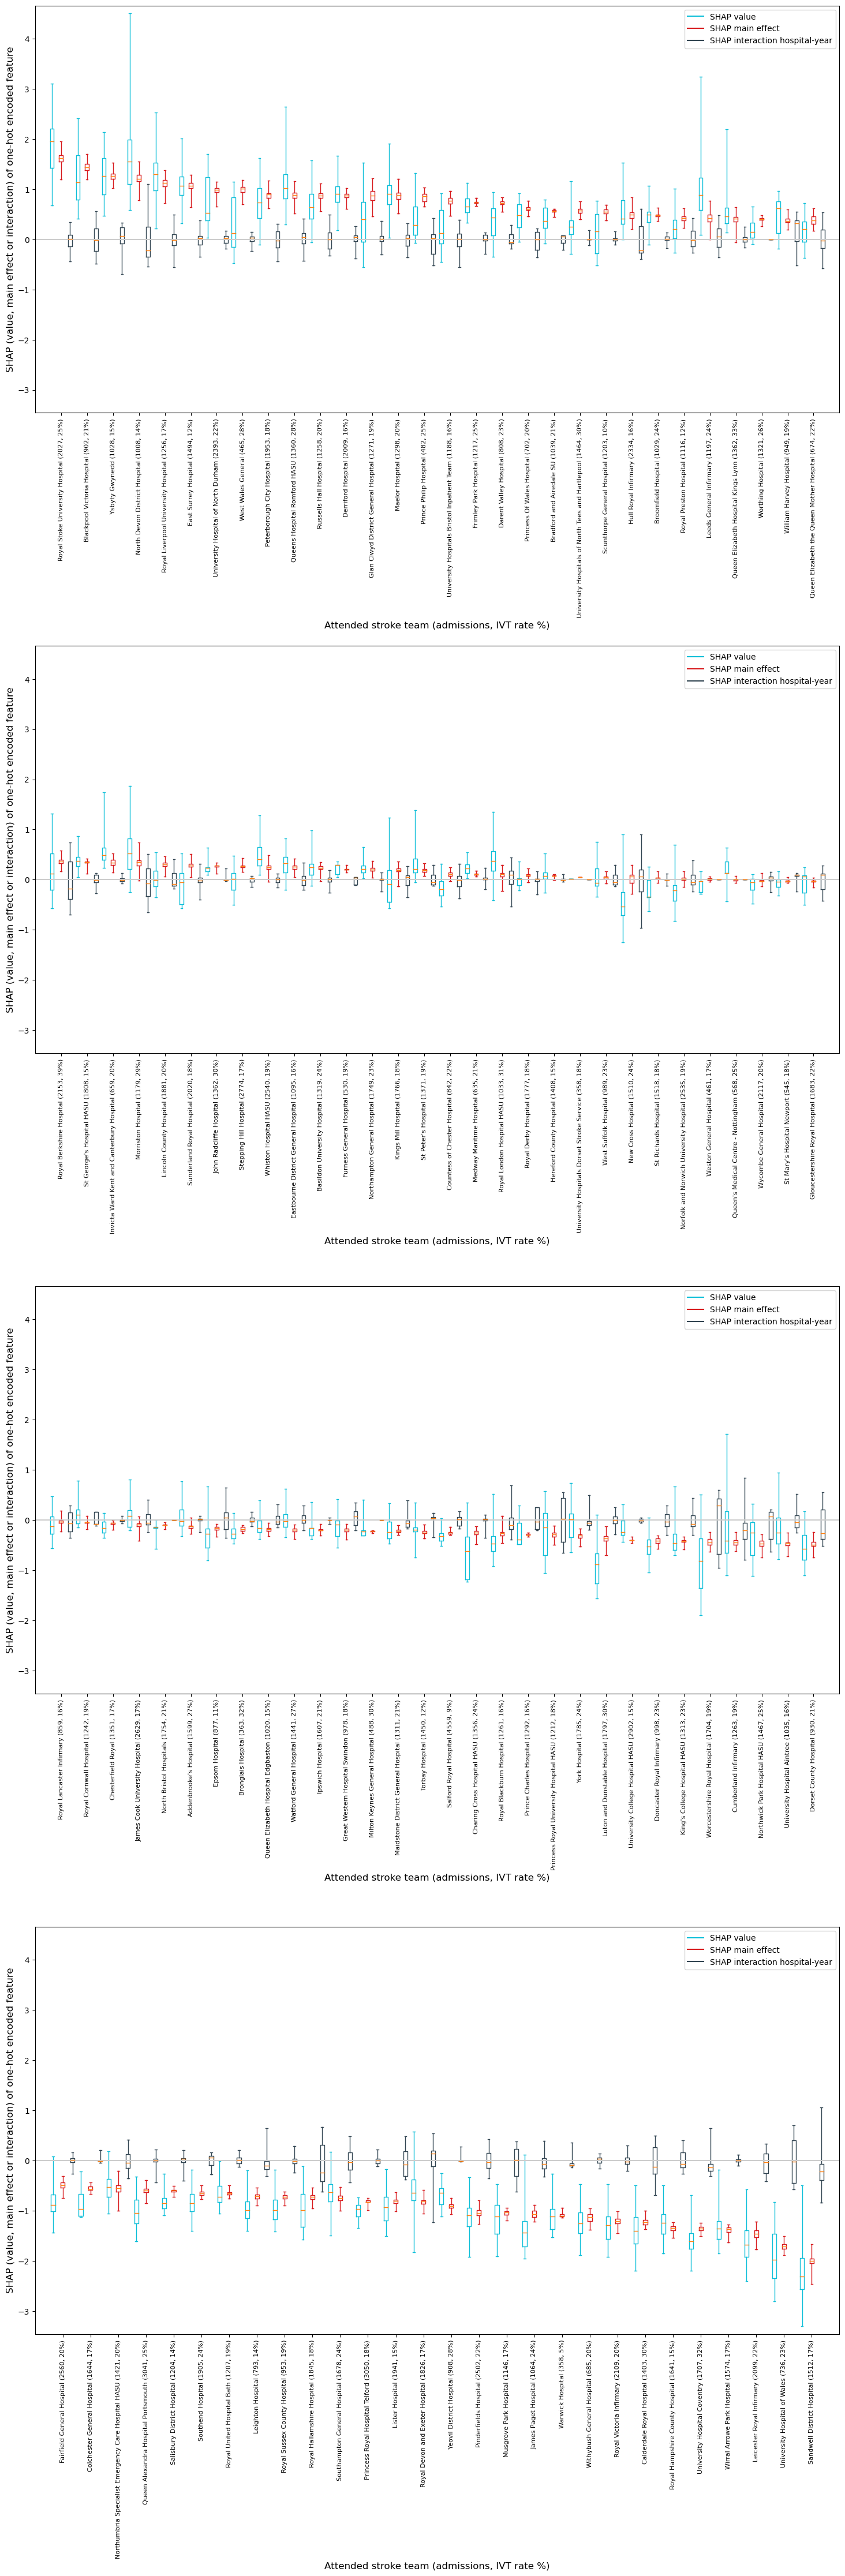

In [65]:
# Plot 34 hospitals on each figure to aid visually
print("Shows the range of contributions to the prediction from this hospital "
      "when patients attend this hosptial")

n_hospitals = len(hospital_names_ohe)

# To group the hospitals into 34
st = 0
ed = 30#34
inc = ed
max_size = n_hospitals
n_subplots = int(round(n_hospitals/ed,0))

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin = min(min(sv_attend_stroketeam_groups_ordered, key=min))
ymax = max(max(sv_attend_stroketeam_groups_ordered, key=max))

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure
fig = plt.figure(figsize=(15,45))

# Create four subplots (divide the 132 hospitals across these to ai visability)
for subplot in range(n_subplots):#4):
    ax = fig.add_subplot(n_subplots,1,subplot+1)
    
    # The contribution from this hospital when patients do not attend this
    #   hospital
    ticks = xlabel[st:ed]
    
    pos_sv = np.array(range(
                    len(sv_attend_stroketeam_groups_ordered[st:ed])))*2.0-0.7
    bp_sv = plt.boxplot(sv_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_sv, sym='', whis=99999, widths=0.3)
    
    pos_me = np.array(range(len(
                        me_attend_stroketeam_groups_ordered[st:ed])))*2.0
    bp_me = plt.boxplot(me_attend_stroketeam_groups_ordered[st:ed], 
                        positions=pos_me, sym='', whis=99999, widths=0.3)

    pos_ysi = np.array(range(len(
                        ysi_attend_stroketeam_groups_ordered[st:ed])))*2.0+0.7
    bp_ysi = plt.boxplot(ysi_attend_stroketeam_groups_ordered[st:ed],
                        positions=pos_ysi, sym='', whis=99999, widths=0.3)

    # colors are from http://colorbrewer2.org/
    set_box_color(bp_sv, '#0bbed8')
    set_box_color(bp_me, '#D7191C') 
    set_box_color(bp_ysi, '#314451')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#0bbed8', label='SHAP value')
    plt.plot([], c='#D7191C', label='SHAP main effect')
    plt.plot([], c='#314451', label='SHAP interaction hospital-year')
    plt.legend()

    #314451'

    plt.xticks(range(0, len(ticks) * 2, 2), ticks, size=8)
    plt.xlim(-2, len(ticks)*2)
    plt.ylim(ymin, ymax)
    plt.tight_layout()
    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
    plt.ylabel('SHAP (value, main effect or interaction) of one-hot encoded feature', 
               size=12)
    plt.xlabel('Attended stroke team (admissions, IVT rate %)', size=12)
    plt.xticks(rotation=90)
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)
    
plt.subplots_adjust(bottom=0.25, wspace=0.05)    
plt.tight_layout(pad=2)
plt.savefig(f'./{paths.output_save_path}{paths.notebook}_{paths.model_text}_individual_hosp_shap_value_'
            f'main_effect_interaction_attend_vs_notattend_boxplot.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()